By Mohammad reza Nilchiyan

In [1]:
import pandas as pd
import numpy as np

# ---------------------------
# Step 0: Load datasets
# ---------------------------
tx_path = "/Users/mohammadrezanilchiyan/Desktop/UE/Datascientest/project/Temperature/Data/processed_2025.12.15/Marseille_daily_TX_raw.csv"
wind_path = "/Users/mohammadrezanilchiyan/Desktop/UE/Datascientest/project/Temperature/Data/processed_2025.12.15/temp_wind_marseille.csv"


In [2]:
df_tx = pd.read_csv(tx_path, parse_dates=["date"])
df_wind = pd.read_csv(wind_path, parse_dates=["date"])

In [3]:
# Keep only relevant columns
df_tx = df_tx[["date", "TX", "NOM_USUEL"]]
df_wind = df_wind.dropna(subset=["wind_max_inst_ms", "temp_max_c", "wind_dir_inst_deg", "wind_mean_10m_ms"])
df_wind = df_wind.rename(
    columns={
        "wind_max_inst_ms": "Wx",
        "temp_max_c": "Tx",
        "wind_dir_inst_deg": "Wx_dir",
        "wind_mean_10m_ms": "Wm_10"
    }
)


In [4]:
# Merge
df_merged = df_tx.merge(df_wind, on="date", how="inner").sort_values("date").reset_index(drop=True)


In [5]:
# ---------------------------
# Step 1: Wind direction encoding
# ---------------------------
df_merged["Wx_dir_rad"] = np.deg2rad(df_merged["Wx_dir"])
df_merged["Wx_dir_sin"] = np.sin(df_merged["Wx_dir_rad"])
df_merged["Wx_dir_cos"] = np.cos(df_merged["Wx_dir_rad"])

In [6]:
# ---------------------------
# Step 2: Seasonal encoding (cyclical features)
# ---------------------------
df_merged["Day_of_year"] = df_merged["date"].dt.dayofyear
df_merged["doy_sin"] = np.sin(2 * np.pi * df_merged["Day_of_year"] / 365)
df_merged["doy_cos"] = np.cos(2 * np.pi * df_merged["Day_of_year"] / 365)

In [7]:
# ---------------------------
# Step 3: Feature engineering
# ---------------------------
# Low wind indicator
df_merged["low_wind"] = (df_merged["Wx"] < 2).astype(int)

# Wind × season interaction
df_merged["wind_season_interaction"] = df_merged["Wx"] * df_merged["doy_sin"]

In [8]:
# ---------------------------
# Step 4: Prepare target
# ---------------------------
df_merged["extreme_heat"] = (df_merged["TX"] >= 35).astype(int)

# Select features (do NOT include TX as predictor)
features = [
    "Wx",
    "Wm_10",
    "Wx_dir_sin",
    "Wx_dir_cos",
    "low_wind",
    "doy_sin",
    "doy_cos",
    "wind_season_interaction"
]
X = df_merged[features]
y = df_merged["extreme_heat"]

In [9]:
# --------------------------------------
# Step 5: Train/test split (stratified)
# --------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # maintain class balance
    random_state=42
)

In [10]:
# -------------------------------------
# Step 6: Oversampling on training set
# -------------------------------------
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Class distribution before oversampling:")
print(y_train.value_counts())
print("Class distribution after oversampling:")
print(pd.Series(y_train_res).value_counts())

Class distribution before oversampling:
extreme_heat
0    394526
1      2730
Name: count, dtype: int64
Class distribution after oversampling:
extreme_heat
0    394526
1    394526
Name: count, dtype: int64


In [11]:
# ---------------------------
# Step 7: Train Gradient Boosting
# ---------------------------
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb.fit(X_train_res, y_train_res)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,300
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [12]:
# ---------------------------
# Step 8: Predictions
# ---------------------------
risk_prob = gb.predict_proba(X_test)[:, 1]  # probability of extreme heat
y_pred = (risk_prob >= 0.25).astype(int)   # threshold lowered for rare events

In [13]:
# ---------------------------
# Step 9: Evaluation
# ---------------------------
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

auc = roc_auc_score(y_test, risk_prob)
print("ROC-AUC:", auc)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     98632
           1       0.04      1.00      0.07       683

    accuracy                           0.82     99315
   macro avg       0.52      0.91      0.48     99315
weighted avg       0.99      0.82      0.89     99315

Confusion Matrix:
[[80604 18028]
 [    0   683]]
ROC-AUC: 0.9563715894045476


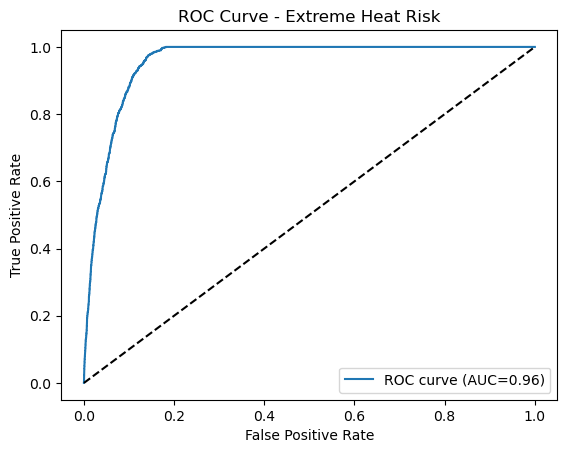

In [14]:
# ---------------------------
# Step 10: Optional: plot ROC
# ---------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, risk_prob)
plt.plot(fpr, tpr, label=f"ROC curve (AUC={auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Extreme Heat Risk")
plt.legend()
plt.show()